# Example of Generative Adversarial Network


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

Using TensorFlow backend.


## Parameters 

In [12]:
n_images = 12000
img_shape = (128, 128, 3)

## Database

In [4]:
data_dir = '../input/google-icons/Google_Icons/' 
images = os.listdir(data_dir)
images = images[:n_images]

## Display Real Images

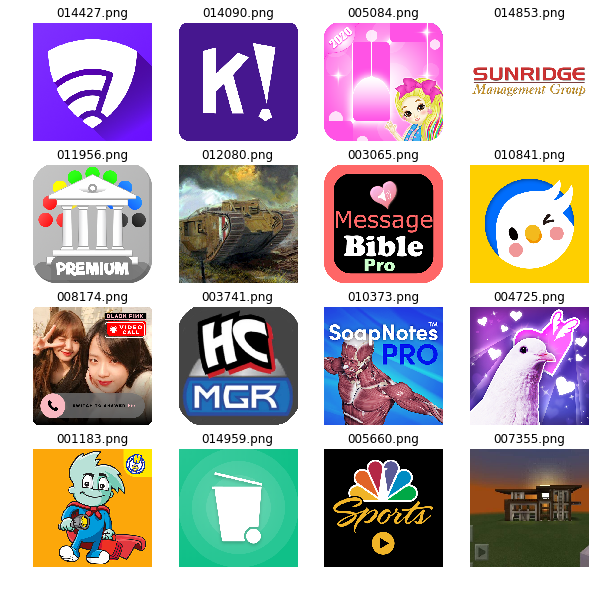

In [5]:
plt.figure(figsize=(10,10))
for i, name in enumerate(images[:16]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data_dir + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

# GET DATA 

In [6]:
def preprocess_database(data_path, freq_display=1000) :
    X = []
    inc=0
    for filename in data_path :
        try:
            img = img_to_array(load_img(data_dir + "/" + filename, target_size = img_shape[:2]))
            X.append(img)
            inc+=1
            if inc%freq_display==0: print(str(inc)+' files registred')
        except:
            print("Problem with "+filename)
          
    X = np.array(X).astype('float32')
    X = X / 255
    return X

dataset = preprocess_database(images)

Problem with 012544.png
Problem with 014889.png
Problem with 000339.png
Problem with 000938.png
Problem with 002770.png
Problem with 003233.png
Problem with 004673.png
Problem with 014520.png
1000 files registred
Problem with 003157.png
Problem with 000149.png
2000 files registred
Problem with 004757.png
Problem with 001395.png
3000 files registred
Problem with 009621.png
Problem with 004206.png
4000 files registred
5000 files registred
Problem with 012942.png
Problem with 007498.png
Problem with 011005.png
Problem with 013404.png
6000 files registred
Problem with 009847.png
7000 files registred
Problem with 004313.png
Problem with 004150.png
8000 files registred
Problem with 006736.png
9000 files registred
Problem with 003533.png
Problem with 012479.png


/opt/conda/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


10000 files registred
Problem with 004606.png
11000 files registred


# DISCRIMINATOR 

In [7]:
def define_discriminator(in_shape=(128,128,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 64x64
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
#     opt = Adam(lr=0.0002, beta_1=0.5)
    opt='adam'
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# GENERATOR 

In [8]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    
    return model

#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

# GAN 

In [20]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
#     opt = Adam(lr=0.0002, beta_1=0.5)
    opt='adam'
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images
def show_generated(generated,epoch, n=5):
    #[-1,1] -> [0,1] 
    #generated = (generated + 1)/ 2
    #generated = (generated[:n*n] * 127.5) + 127.5
    #generated = generated * 255
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.subplot(1,n, i + 1)
        #img = plt.imread(data_dir + '/' + name)
        plt.imshow(generated[i])
        #plt.title(name)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()    

# evaluate the discriminator and plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))
    # show plot
#     show_generated(x_fake, epoch)    

# TRAIN 

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1,  Loss: D_real = 0.024, D_fake = 0.022,  G = 7.752


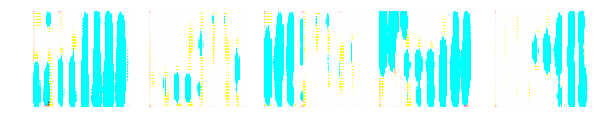

Epoch: 2,  Loss: D_real = 0.000, D_fake = 0.001,  G = 9.267


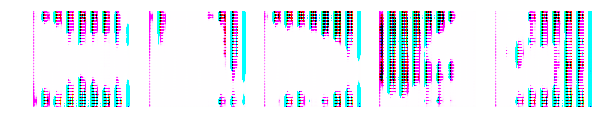

Epoch: 3,  Loss: D_real = 0.007, D_fake = 0.000,  G = 15.026


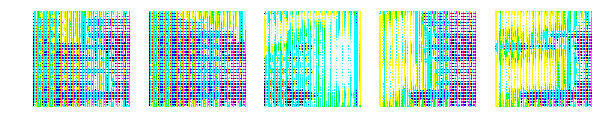

Epoch: 4,  Loss: D_real = 0.000, D_fake = 0.001,  G = 10.418


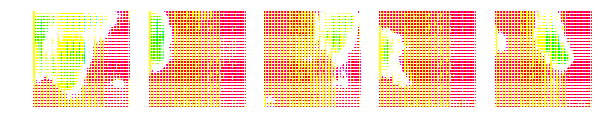

Epoch: 5,  Loss: D_real = 0.000, D_fake = 0.000,  G = 12.136


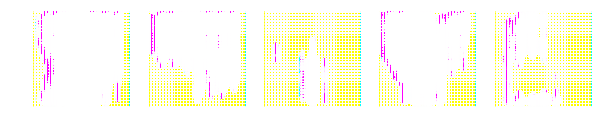

Epoch: 6,  Loss: D_real = 0.000, D_fake = 0.000,  G = 19.080


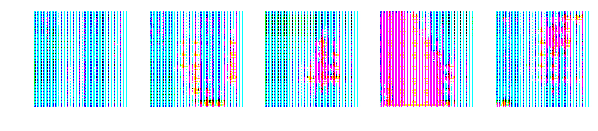

Epoch: 7,  Loss: D_real = 0.000, D_fake = 0.000,  G = 11.084


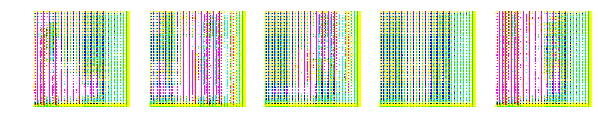

Epoch: 8,  Loss: D_real = 0.000, D_fake = 0.000,  G = 13.276


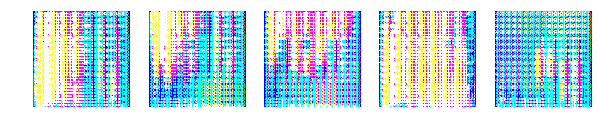

Epoch: 9,  Loss: D_real = 0.001, D_fake = 0.000,  G = 31.000


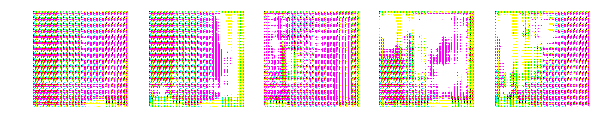

Epoch: 10,  Loss: D_real = 0.000, D_fake = 0.000,  G = 18.673


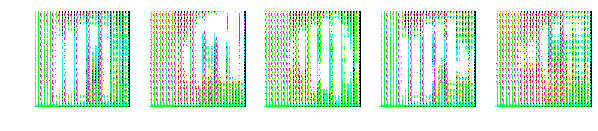

Epoch: 11,  Loss: D_real = 0.000, D_fake = 0.000,  G = 11.271


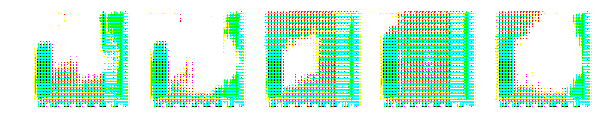

Epoch: 12,  Loss: D_real = 0.000, D_fake = 0.000,  G = 21.768


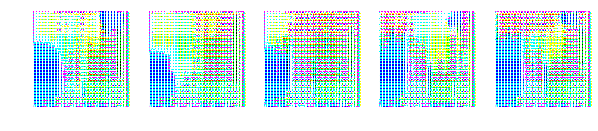

Epoch: 13,  Loss: D_real = 0.000, D_fake = 0.000,  G = 18.645


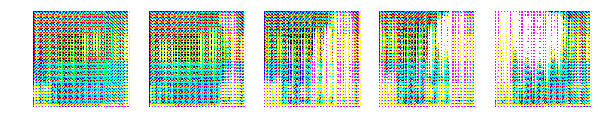

Epoch: 14,  Loss: D_real = 0.001, D_fake = 0.000,  G = 31.623


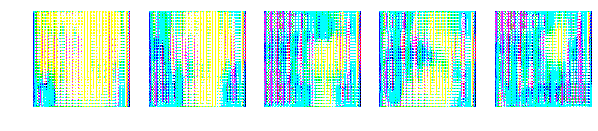

Epoch: 15,  Loss: D_real = 0.000, D_fake = 0.000,  G = 24.732


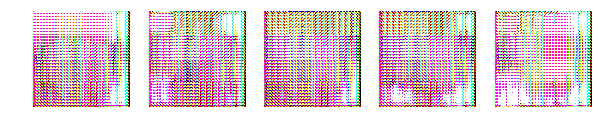

Epoch: 16,  Loss: D_real = 0.000, D_fake = 0.002,  G = 9.972


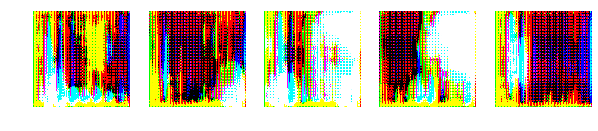

Epoch: 17,  Loss: D_real = 0.000, D_fake = 0.000,  G = 11.621


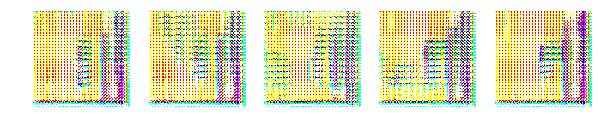

Epoch: 18,  Loss: D_real = 0.000, D_fake = 0.000,  G = 10.763


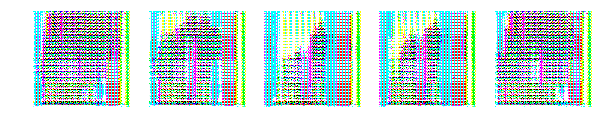

Epoch: 19,  Loss: D_real = 0.000, D_fake = 0.000,  G = 13.297


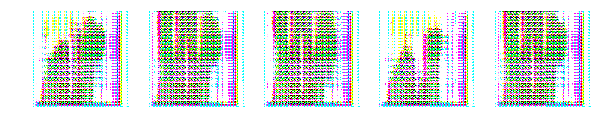

Epoch: 20,  Loss: D_real = 0.001, D_fake = 0.000,  G = 20.935


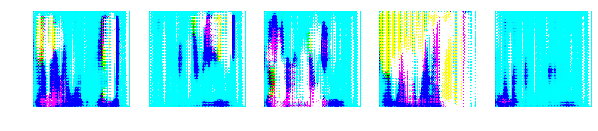

>Accuracy [real: 91%, fake: 0%]


OSError: Unable to create file (unable to open file: name = '../input/generator', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)

In [21]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=64, 
          period_newDisplay=1, period_checkPerfs=20, period_save=20):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    start = time.time()
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))
        
        # Generate new fake images
        if (i+1) % period_newDisplay == 0:
            generated, _ = generate_fake_samples(g_model, latent_dim, 5)
            show_generated(generated,i, n=5)
            
        # evaluate the model performance
        if (i+1) % period_checkPerfs == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     
        # local save
        if (i+1) % period_save == 0:
            g_model.save('../input/generator') 
            d_model.save('../input/discriminator') 
    print ('Total time for training {} epochs is {} sec'.format(n_epochs, (time.time()-start)))
    g_model.save('../input/generator') 
    d_model.save('../input/discriminator') 
    
FLAG_USED_PRETRAINED = False
batch_size = 64
latent_dim = 256
n_epoch = 200

if FLAG_USED_PRETRAINED: #Use pre-trained 
    pass
else:
    discriminator = define_discriminator()
    generator = define_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)

# CREATE GIF

In [ ]:
files = []
n_iter = int(n_epoch / 10 -1)
for e in range(n_iter):
    img_name = '../working/image_at_epoch_{:04d}.png'.format((e+1)*10)
    files.append(imageio.imread(img_name))
imageio.mimsave('dcgan_celebA_generation_animation.gif', files, fps=5)

## You can see the GIF at the end of the kernel! 